<a href="https://colab.research.google.com/github/WojciechSokolowski/Qiskit_Projects/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install galois


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     

In [47]:
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import math
from math import pi
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.circuit.library import MCMT
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info import Statevector, DensityMatrix, Operator

import galois
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

In [48]:
def simon_function(s: str):
    """
    Create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    # Our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which
    # is a simple function that satisfies the promise, and then we take f to be the composition of g and the random
    # permutation pi. This gives us a random function satisfying the promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [49]:


def simon_measurements(problem: QuantumCircuit, k: int):
    """
    Quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get `k` measurements to be post-processed later.
    """
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = Sampler().run(qc, shots=k).result().quasi_dists[0].binary_probabilities()
    display(plot_histogram(result))
    return result

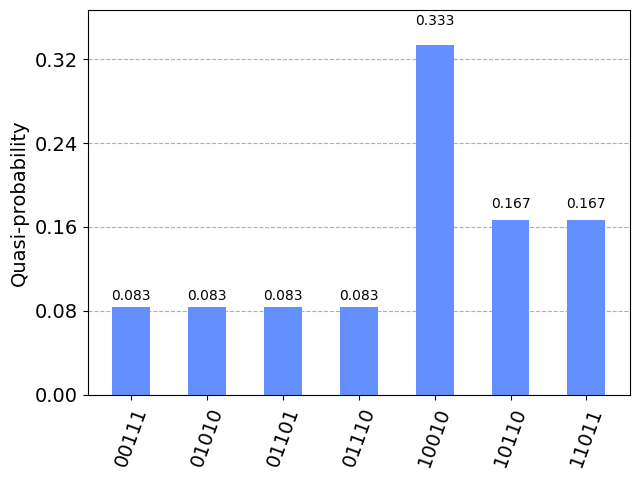

{'00111': 0.08333333333333333,
 '01010': 0.08333333333333333,
 '01101': 0.08333333333333333,
 '01110': 0.08333333333333333,
 '10010': 0.3333333333333333,
 '10110': 0.16666666666666666,
 '11011': 0.16666666666666666}

In [50]:
simon_measurements(simon_function("11011"),k=12)

In [51]:

def simon_algorithm(problem: QuantumCircuit):
    """
    Given a `QuantumCircuit` that implements a query gate for Simon problem, return the hidden string `s`.
    """

    # Quantum part: run the circuit defined previously k times and gather the measurement results.
    # Replace +10 by +r for any nonnegative integer r depending on desired confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 +10)
    print("Measurement results:")
    display(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    print(matrix)
    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:")
    display(null_space)

    # 3. Convert back to a string
    print("Guess for hidden string s:")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

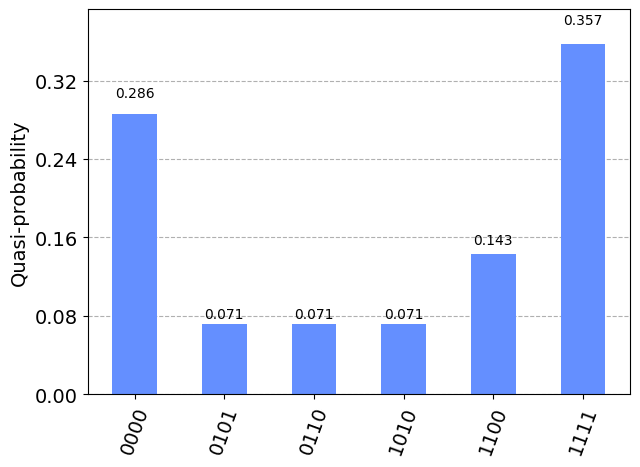

Measurement results:


{'0000': 0.2857142857142857,
 '0101': 0.07142857142857142,
 '0110': 0.07142857142857142,
 '1010': 0.07142857142857142,
 '1100': 0.14285714285714285,
 '1111': 0.35714285714285715}

[[0 0 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 1 1]]
Null space:


GF([[1, 1, 1, 1]], order=2)

Guess for hidden string s:


'1111'

In [52]:
display(simon_algorithm(simon_function("1111")))

 ### quantum phase estimation algorithm

In [53]:
def quantum_phase_estimator_circuit(theta,n,draw=False):
  qpe = QuantumCircuit(n+1, n)
  qpe.x(n)
  qpe.h(range(n))

  qpe.barrier()


  for counting_qubit in range(n):
    reps = 2**(counting_qubit)
    for i in range(reps):
      qpe.cp(2*theta*pi,counting_qubit,n)

  qpe.barrier()

  qpe.compose(QFT(n, inverse=True),inplace=True)

  qpe.barrier()

  qpe.measure(range(n), range(n))




  result = Sampler().run(qpe).result()

  if draw:
    display(qpe.draw('mpl'))
    display(plot_histogram(result.quasi_dists))
    most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)
    print(f"Most probable output: {most_probable}")
    print(f"Outome for inputed theta: {theta*2**n}")
    print(f"Estimated theta: {most_probable/2**n}")
  return max(result.quasi_dists[0], key=result.quasi_dists[0].get)/2**n

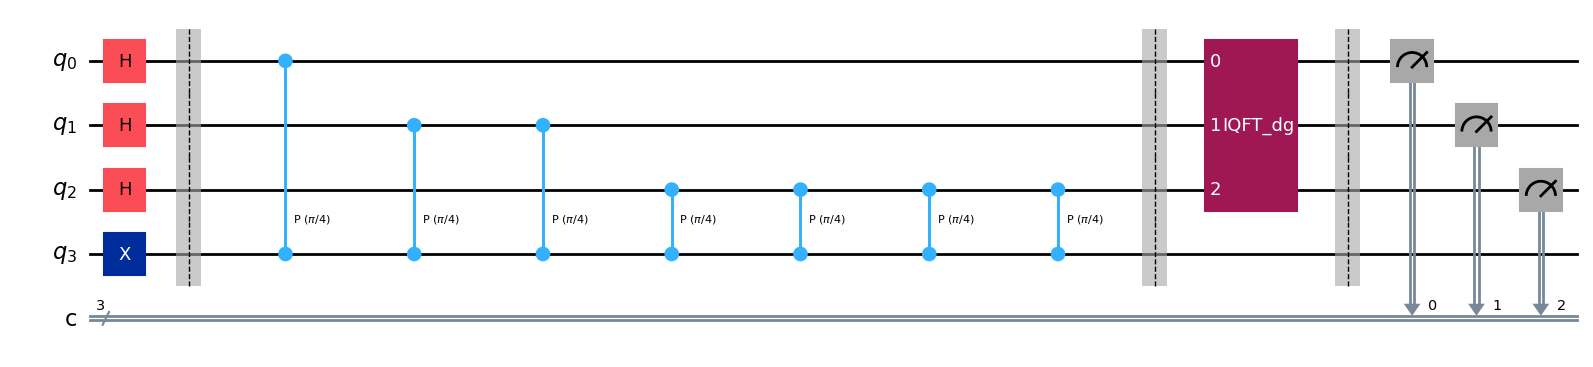

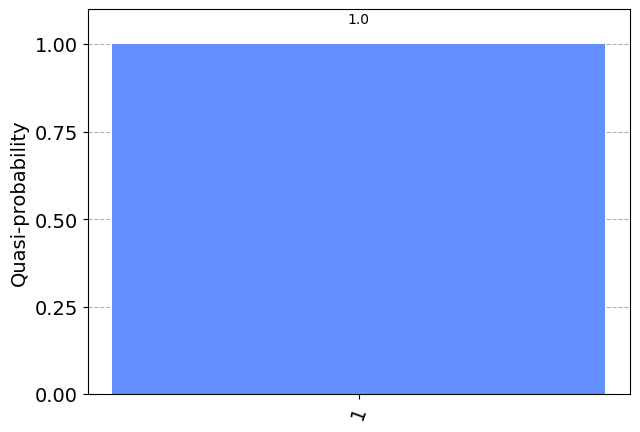

Most probable output: 1
Outome for inputed theta: 1.0
Estimated theta: 0.125


0.125

In [54]:
quantum_phase_estimator_circuit(1/8,3,True)

When the 2ⁿθ is intiger we get probability 1 for the value corresponding to the inputed θ

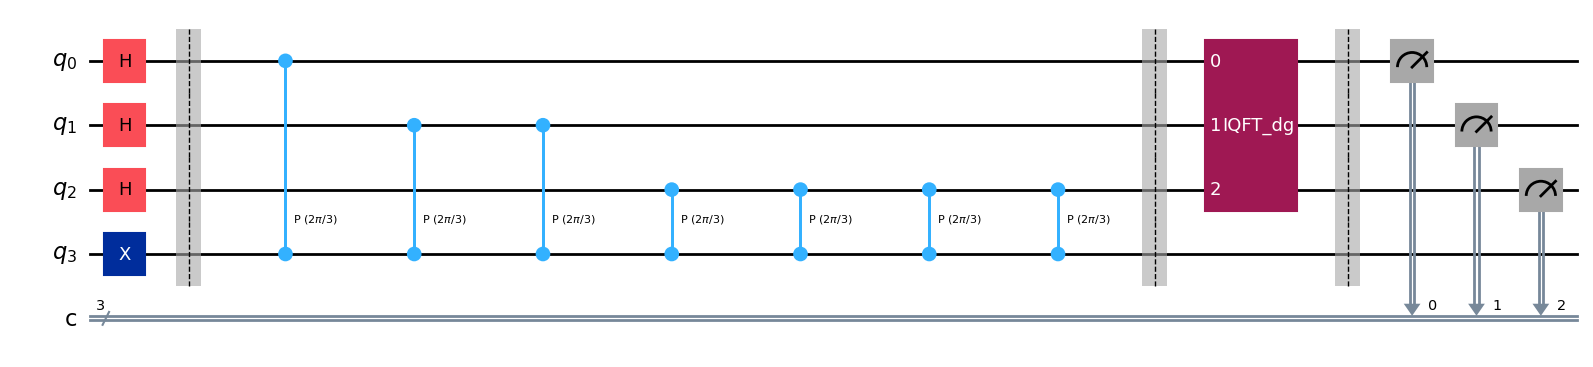

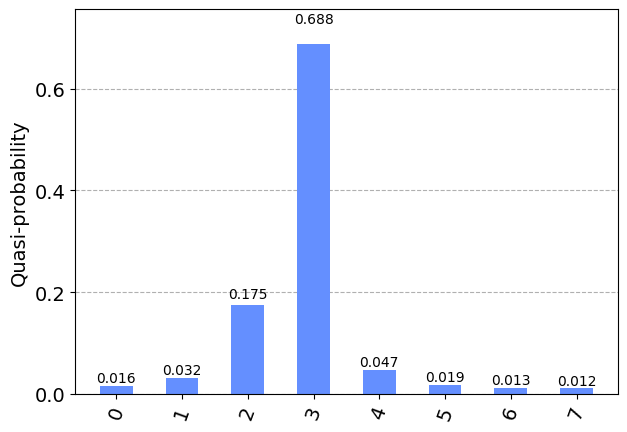

Most probable output: 3
Outome for inputed theta: 2.6666666666666665
Estimated theta: 0.375


0.375

In [55]:
quantum_phase_estimator_circuit(1/3,3,True)

When the 2ⁿθ is not an intiger we get distribution, the biggest probability corresponds to the nearest value to 2ⁿθ


In [56]:
def estimate_theta (theta,n_max:int,n_min=1):
  estimations = np.zeros(n_max-n_min+1)
  differences = np.zeros(n_max-n_min+1)

  n_tab = np.linspace(n_min,n_max,n_max-n_min+1)


  for i in range(n_max-n_min+1):
    estimations[i] = quantum_phase_estimator_circuit(theta,int(n_tab[i]))
    differences[i] = abs(estimations[i]-theta)
    #print(estimations[i])

  #print(n_tab)
  #print(estimations)
  plt.plot(n_tab,estimations,'r--.')
  plt.axhline(y=theta,color='k')
  plt.xlabel('number of counting qubits')
  plt.ylabel(r'estimated $\theta$')
  plt.show()


  plt.plot(n_tab,differences,'r--.')

  plt.xlabel('number of counting qubits')
  plt.ylabel(r' $|\theta_{est}-\theta|$')
  plt.grid()
  plt.show()

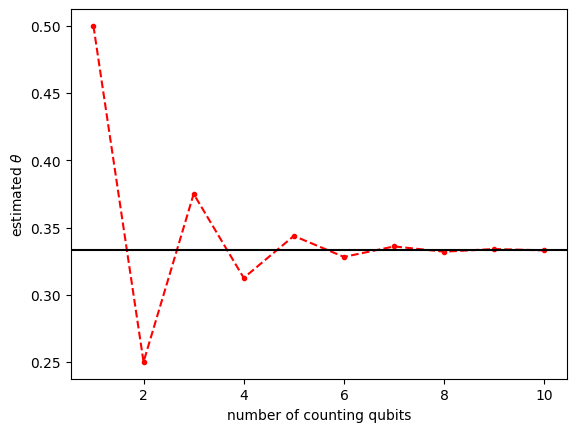

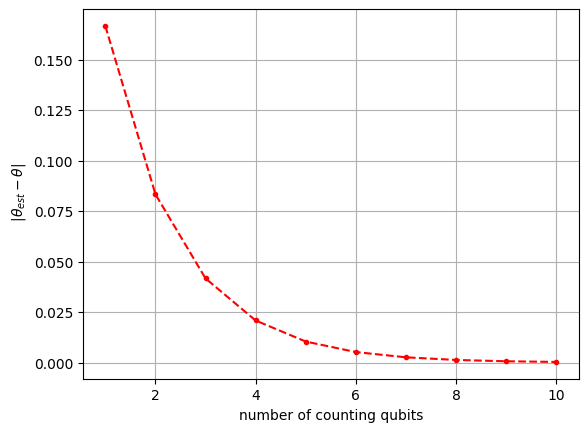

In [ ]:
estimate_theta(1/3,10)

The more qbits in counting register the closer estimated theta is to